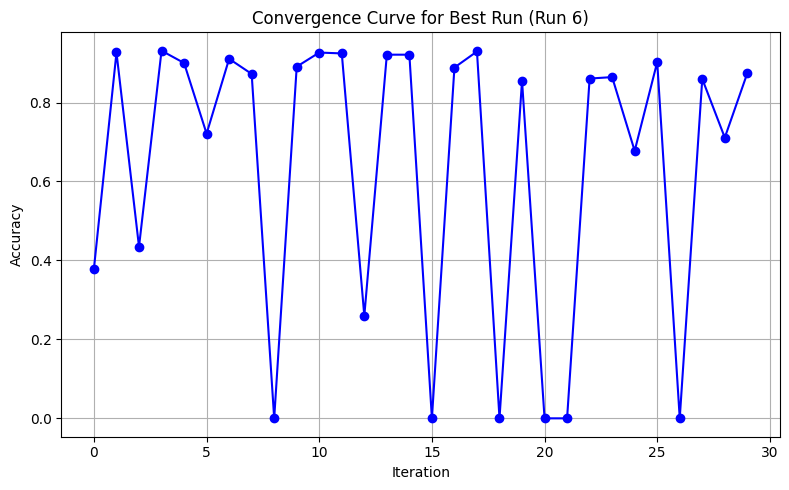

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import NuSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
data = pd.read_excel("/content/Dry_Bean_Dataset.xlsx")

# Encode class labels
label_encoder = LabelEncoder()
data['Class'] = label_encoder.fit_transform(data['Class'])

# Separate features and target
features = data.drop(columns=['Class'])
target = data['Class']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# SVM parameter grid
kernel_choices = ['linear', 'rbf', 'poly', 'sigmoid']
nu_choices = np.round(np.unique(np.linspace(0.01, 0.3, 25)), 3)

# Containers for results
final_results = []
fitness_log = []
iterations = 30

# Optimization over multiple splits
for run in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        features_scaled, target, test_size=0.3, stratify=target, random_state=run
    )

    max_accuracy = 0
    top_params = {}
    accuracy_over_iters = []

    for step in range(iterations):
        chosen_kernel = np.random.choice(kernel_choices)
        chosen_nu = np.random.choice(nu_choices)

        try:
            clf = NuSVC(kernel=chosen_kernel, nu=chosen_nu)
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            acc = accuracy_score(y_test, preds)
        except ValueError:
            acc = 0  # skip bad config

        accuracy_over_iters.append(acc)

        if acc > max_accuracy:
            max_accuracy = acc
            top_params = {'kernel': chosen_kernel, 'nu': chosen_nu}

    final_results.append({
        'Split': f'Run_{run+1}',
        'Top Accuracy (%)': round(max_accuracy * 100, 2),
        'Top Params': f"{top_params.get('kernel', '-')}, nu={round(top_params.get('nu', 0), 2)}"
    })
    fitness_log.append(accuracy_over_iters)

# Save results to Excel
results_df = pd.DataFrame(final_results)
results_df.to_excel("NuSVC_Optimization_Results.xlsx", index=False)

# Plot convergence for the best split
top_index = np.argmax([res['Top Accuracy (%)'] for res in final_results])
best_fitness = fitness_log[top_index]

plt.figure(figsize=(8, 5))
plt.plot(best_fitness, color='blue', marker='o', linestyle='-')
plt.title(f"Convergence Curve for Best Run (Run {top_index + 1})")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("NuSVC_Convergence_BestRun.png")
plt.show()
